<a href="https://colab.research.google.com/github/farhanfuadabir/Nurse-Care-Challenge-2020/blob/main/LSTM_Nurse_Care_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
# cnn model
import numpy as np
import pandas as pd
from matplotlib import pyplot
from joblib import load, dump
from tqdm.notebook import tqdm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

# Process Windowed Dataset for LSTM

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
  dataframe = load(filepath)
  return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, path):
	loaded = list()
	for name in filenames:
		data = load_file(path + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, path):
	# load all 3 files as a single array
	filenames = ['acc_x_' + group + '.joblib', 'acc_y_' + group + '.joblib', 
              'acc_z_' + group + '.joblib']
	# load input data
	X = load_group(filenames, path)
	# load class output
	y = load_file(path + 'label_' + group + '.joblib')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(path):
  # load all train
  trainX, trainy = load_dataset_group('train', path)
  print('trainX shape: ', trainX.shape, '   |   trainy shape: ', trainy.shape)
  # load all test
  testX, testy = load_dataset_group('test', path)
  print('testX shape: ', testX.shape, '   |   testy shape: ', testy.shape)
  # zero-offset class values
  trainy = trainy - 1
  testy = testy - 1
  # one hot encode y
  trainy = to_categorical(trainy)
  testy = to_categorical(testy)
  print('Final Dataset shape: \n\nTrain Set: ', end='')
  print(trainX.shape, '<----->', trainy.shape, '\nTest Set: ', testX.shape, '<----->', testy.shape)
  return trainX, trainy, testX, testy

In [ ]:
# load data
dataset_path = '/content/drive/MyDrive/NCC Train Test Set (Resampled 20Hz)/Split 80 20/Windowed 250/'
trainX, trainy, testX, testy = load_dataset(dataset_path)

trainX shape:  (93838, 250, 3)    |   trainy shape:  (93838,)
testX shape:  (22775, 250, 3)    |   testy shape:  (22775,)
Final Dataset shape: 

Train Set: (93838, 250, 3) <-----> (93838, 12) 
Test Set:  (22775, 250, 3) <-----> (22775, 12)


# LSTM Model

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['categorical_accuracy', f1_m, precision_m, recall_m])
  # fit network
  # model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # # evaluate model
  # _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  import time
  t_start = time.clock()
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

  t_end = time.clock()

  print('\n\n\n')

  #_, accuracy_train = model.evaluate(X_train, y_train)
  loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model.evaluate(trainX, trainy, verbose=1)
  print('Train Accuracy: %.2f' % (accuracy_train*100))
  print('Train F1 Score: %.2f' % (f1_score_train*100))
  print('Train Time: ', t_end - t_start)

  t_start = time.clock()
  #_, accuracy_test = model.evaluate(X_test, y_test)
  loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(testX, testy, verbose=1)
  print('Test Accuracy: %.2f' % (accuracy_test*100))
  print('Test F1 Score: %.2f' % (f1_score_test*100))
  t_end = time.clock()
  print('Test Time: ', t_end - t_start)

  return f1_score_test, history
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10, verbose=True, epochs=10, batch_size=32):
  # repeat experiment
  scores = list()
  for r in tqdm(range(repeats)):
    score, history = evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size)
    print('%.3f' % (score * 100.0))
    scores.append(score)
  # summarize results
  summarize_results(scores)

## Train

Epoch 1/100
2933/2933 [==============================] - 43s 12ms/step - loss: 1.0858 - categorical_accuracy: 0.6016 - f1_m: 0.5388 - precision_m: 0.7268 - recall_m: 0.4341
Epoch 2/100
2933/2933 [==============================] - 35s 12ms/step - loss: 0.9606 - categorical_accuracy: 0.6353 - f1_m: 0.5836 - precision_m: 0.7627 - recall_m: 0.4767
Epoch 3/100
2933/2933 [==============================] - 35s 12ms/step - loss: 0.9356 - categorical_accuracy: 0.6380 - f1_m: 0.5957 - precision_m: 0.7562 - recall_m: 0.4953
Epoch 4/100
2933/2933 [==============================] - 35s 12ms/step - loss: 0.8892 - categorical_accuracy: 0.6480 - f1_m: 0.6175 - precision_m: 0.7543 - recall_m: 0.5261
Epoch 5/100
2933/2933 [==============================] - 36s 12ms/step - loss: 0.8725 - categorical_accuracy: 0.6622 - f1_m: 0.6409 - precision_m: 0.7591 - recall_m: 0.5577
Epoch 6/100
2933/2933 [==============================] - 35s 12ms/step - loss: 0.8854 - categorical_accuracy: 0.6541 - f1_m: 0.6357 - p

KeyError: ignored

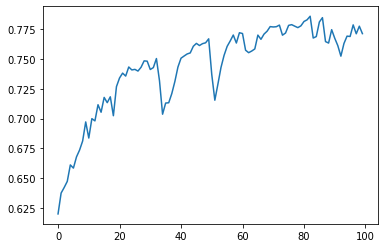

In [ ]:
# for single iteration
score, history = evaluate_model(trainX, trainy, testX, testy, verbose=True, epochs=100, batch_size=32)
print('Score:', '%.3f' % (score * 100.0))

##### Epoch = 100, Batch Size = 32
```

2933/2933 [==============================] - 18s 6ms/step - loss: 0.5709 - categorical_accuracy: 0.7615 - f1_m: 0.7288 - precision_m: 0.7738 - recall_m: 0.7057
Train Accuracy: 76.15
Train F1 Score: 72.88
Train Time:  3794.4624440000007
712/712 [==============================] - 4s 6ms/step - loss: 1.3527 - categorical_accuracy: 0.6923 - f1_m: 0.6779 - precision_m: 0.6956 - recall_m: 0.6671
Test Accuracy: 69.23
Test F1 Score: 67.79
Test Time:  5.017310999999609
```

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# run the experiment for interations
run_experiment(10, verbose=False, epochs=80, batch_size=32)





2933/2933 [==============================] - 18s 6ms/step - loss: 0.5617 - categorical_accuracy: 0.7728 - f1_m: 0.7457 - precision_m: 0.7828 - recall_m: 0.7272
Train Accuracy: 77.28
Train F1 Score: 74.57
Train Time:  2611.6818349999994
712/712 [==============================] - 4s 6ms/step - loss: 1.0947 - categorical_accuracy: 0.7244 - f1_m: 0.7114 - precision_m: 0.7332 - recall_m: 0.6977
Test Accuracy: 72.44
Test F1 Score: 71.14
Test Time:  5.214239000000816
71.142




2933/2933 [==============================] - 19s 6ms/step - loss: 0.6983 - categorical_accuracy: 0.7242 - f1_m: 0.6495 - precision_m: 0.7287 - recall_m: 0.6209
Train Accuracy: 72.42
Train F1 Score: 64.95
Train Time:  2593.2486659999995
712/712 [==============================] - 4s 6ms/step - loss: 1.0228 - categorical_accuracy: 0.6784 - f1_m: 0.6370 - precision_m: 0.6721 - recall_m: 0.6261
Test Accuracy: 67.84
Test F1 Score: 63.70
Test Time:  5.240935999998328
63.703




2933/2933 [==============================] -

# Random Forest Model

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# load label set again
trainy_2 = load_file(dataset_path + 'label_train.joblib')
testy_2 = load_file(dataset_path + 'label_test.joblib')

clf = RandomForestClassifier(verbose=True,n_jobs=-1)

clf.fit(trainX, trainy_2)
y_pred = clf.predict(testX)

# Evaluate Algorithm
print("\n\nConfusion Matrix: \n\n",confusion_matrix(testy_2,y_pred))
print("\n\nReport: \n\n",classification_report(testy_2,y_pred))
print("Accuracy: ",accuracy_score(testy_2,y_pred))